# Icon Understanding with PaliGemma and Structured Generation

NOTE: useless

In [1]:
import os
import json
import base64
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from io import BytesIO

import pandas as pd
import huggingface_hub
from PIL import Image, ImageOps
from PIL.Image import Image as PILImage
from transformers import AutoProcessor
from transformers.image_processing_utils import select_best_resolution

/home/leloykun/anaconda3/envs/MMFM-Challenge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_REPO = "google/paligemma-3b-mix-448"
MODEL_NAME = MODEL_REPO.split("/")[1]

HUGGINGFACE_INFERENCE_API_URL = "https://vft8ld0gc42q74xj.us-east-1.aws.endpoints.huggingface.cloud"

PROMPT_FORMAT = "<image>\\n<user>\\n"

In [3]:
processor = AutoProcessor.from_pretrained(
    MODEL_REPO, token="hf_<secret>"
)

In [4]:
# possible_resolutions = processor.image_processor.image_grid_pinpoints
# possible_resolutions += [
#     [672, 1008],
#     [1008, 672],
#     [1008, 1008],
# ]
possible_resolutions = [[448, 448]]

In [5]:
def resize_and_pad_image(image: PILImage) -> PILImage:
    best_resolution = select_best_resolution(image.size, possible_resolutions)
    print(f"{best_resolution = }")
    resized_image = ImageOps.cover(image, best_resolution)
    resized_and_padded_image = ImageOps.pad(
        resized_image,
        best_resolution,
        method=processor.image_processor.resample,
        color=(255,255,255,0),
    )
    return resized_and_padded_image


def encode_local_image(image_path, resize_and_pad: bool=True):
    # load image
    image = Image.open(image_path)
    if ".gif" in image_path:
        image = image.convert("RGB")
    if resize_and_pad:
        image = resize_and_pad_image(image)
        print(f"New size: {image.size}")

    # Convert the image to a base64 string
    buffer = BytesIO()
    image.save(buffer, format="PNG")  # Use the appropriate format (e.g., JPEG, PNG)
    base64_image = base64.b64encode(buffer.getvalue()).decode('utf-8')

    # add string formatting required by the endpoint
    image_string = f"data:image/png;base64,{base64_image}"

    return image_string

In [6]:
def format_title(image_path: str) -> str:
    title = image_path.split("/")[-1].split(".")[0]
    return title.replace("-", " ").replace("_", " ")

In [69]:
def build_tool(question: str):
    is_asking_time = ("what time" in question.lower())
    return {
        "type": "function",
        "function": {
            "name": "icon_vqa_tool",
            "description": "Icon VQA Tool",
            "parameters": {
                "type": "string" if is_asking_time else "integer",
            },
        }
    }

In [70]:
headers = {
	"Accept" : "application/json",
	"Authorization": f"Bearer {huggingface_hub.get_token()}",
	"Content-Type": "application/json" 
}

def query(payload):
	response = requests.post(
		HUGGINGFACE_INFERENCE_API_URL, headers=headers, json=payload
	)
	return response.json()

In [71]:
def run_inference(image_path, question, seed=0):
    image_base64 = encode_local_image(image_path)
    question_trimmed = question[len("<image>\n"):].split("\"")[1]
    # title = format_title(image_path)
    # print(f"{title = } | {question_trimmed = }")
    print(f"{question_trimmed = }")
    tool = build_tool(question_trimmed)

    prompt = (
        PROMPT_FORMAT
        .replace("<image>", f"![]({image_base64})")
        .replace("<user>", f"{question_trimmed}" + ("Fill in the blank (_):" if "(_)" in question else ""))
    )
    print(f"{prompt = }")

    # This version of TGI uses an older version of Outlines
    # which re-orders the keys in the JSON in alphabetical order.
    # Hence the prefixes in the keys in the grammer
    response = query({
        "inputs": prompt,
        "parameters": {
            "return_full_text": False,
            "max_new_tokens": 32,
            # "frequency_penalty": 1,
            # "temperature": 1,
            # "top_p": 0.95,
            "seed": seed,
            # "frequency_penalty": 0,
            # "presence_penalty": 0,
            # "grammar": {
            #     "type": "json",
            #     "value": tool["function"]["parameters"],
            # }
        }
    })
    print(f"{response = }")

    return json.loads(response[0]["generated_text"])["answer"]

best_resolution = (448, 448)


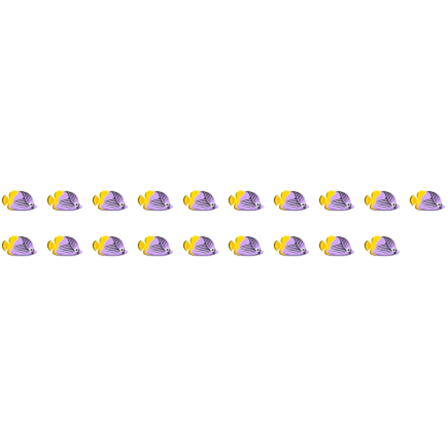

In [72]:
image_path = "data/raw_datasets/iconqa/iconqa_data/iconqa/val/fill_in_blank/20847/image.png"
image = Image.open(image_path)
image = resize_and_pad_image(image)
image

In [ ]:
question = """<image>\nRepresent the icon. Question "How many fish are there?" Fill in the empty spaces:"""
answer = run_inference(image_path, question, seed=460)
answer

In [ ]:
dataset_name = "iconqa_fill_in_blank"
dataset_path = os.path.join("data/processed_data", dataset_name, "converted_output_test.json")
print(dataset_path)
assert os.path.exists(dataset_path)

df_data = pd.read_json(dataset_path)

In [ ]:
!mkdir -p inference_results/$MODEL_NAME

In [ ]:
def run_inference_and_save(
    idx: int,
    answer_txt_path: str,
    image_path: str,
    question: str,
) -> int:
    print(f"Processing {idx}:\n{image_path}\n{question}")
    try:
        answer = run_inference(image_path, question, seed=7812)
        print(f"{answer = }")
        with open(answer_txt_path, "w") as f:
            f.write(str(answer))
        return -1
    except Exception as e:
        print(">>>>>>> ERROR", idx, image_path, question, e, "<<<<<<<")
        return idx

In [ ]:
task_args_list = []
for idx, row in df_data.iterrows():
    id = row["id"]

    answer_txt_path = f"inference_results/{MODEL_NAME}/{dataset_name}_{id}.txt"
    image_path = row['image']
    question = row["conversations"][0]["value"]

    if os.path.exists(answer_txt_path):
        continue

    task_args_list.append((idx, answer_txt_path, image_path, question))
len(task_args_list)

In [ ]:
failed_idx = set()
with ThreadPoolExecutor() as executor:
    running_tasks = [
        executor.submit(run_inference_and_save, *task_args)
        for task_args in task_args_list
    ]
    for running_task in as_completed(running_tasks):
        res = running_task.result(timeout=60)
        if res != -1:
            print(f"ERROR on {res}")
            failed_idx.add(res)

In [ ]:
failed_idx = set()
for idx, row in df_data.iterrows():
    id = row["id"]
    answer_txt_path = f"inference_results/paligemma-mix-448/{dataset_name}_{id}.txt"

    image_path = row['image']
    question = row["conversations"][0]["value"]

    if os.path.exists(answer_txt_path):
        continue
    print(id, idx, question)
    print(image_path)

    try:
        answer = run_inference(image_path, question, seed=7812)
        print(f"{answer = }")
        with open(answer_txt_path, "w") as f:
            f.write(str(answer))
    except Exception as e:
        print(">>>>>>> ERROR", idx, row, e, "<<<<<<<")
        failed_idx.add(idx)
        raise e
    print("---------")
    break

In [31]:
from collections import defaultdict

In [ ]:
len(df_data)

In [ ]:
question_type_cnt = defaultdict(int)
other_question_types = set()
has_blank = set()
for idx, row in df_data[::-1].iterrows():
    conversation = row["conversations"][0]["value"]
    question = conversation.split("\"")[1].lower()
    if "what time" in question:
        print(question)
    if "how many" in question and "(_)" not in question:
        question_type_cnt["how many"] += 1
    elif "(_)" in question:
        question_type_cnt[question] += 1
        has_blank.add(question)
    else:
        question_type_cnt[question] += 1
        other_question_types.add(question)

In [ ]:
question_type_cnt

In [ ]:
other_question_types

In [ ]:
has_blank

In [ ]:
for idx, row in df_data.iterrows():
    id = row["id"]
    answer_txt_path = f"inference_results/llava-1-6-vicuna-13b-hf/{id}.txt"
    if not os.path.exists(answer_txt_path):
        failed_idx.add(idx)
        continue

    with open(answer_txt_path, "r") as f:
        answer = f.read()

    if len(answer) >= 50:
        failed_idx.add(idx)

In [ ]:
failed_idx

In [ ]:
df_data.iloc[list(failed_idx)]

In [ ]:
failed_idx_2 = set()
for idx, row in df_data.iloc[list(failed_idx)].iterrows():
    id = row["id"]
    answer_txt_path = f"inference_results/llava-1-6-vicuna-13b-hf/{id}.txt"
    if os.path.exists(answer_txt_path):
        os.remove(answer_txt_path)
    print(id, idx)

    image_path = f"data/raw_datasets/{dataset_name}/images/{row['image']}"
    question = row["conversations"][0]["value"]

    try:
        answer = run_inference(image_path, question, seed=42)
        with open(answer_txt_path, "w") as f:
            f.write(answer)
    except Exception as e:
        print(idx, row, e)
        failed_idx_2.add(idx)

In [ ]:
failed_idx_2

In [ ]:
df_data.iloc[220]["image"]

In [ ]:
df_data.iloc[220]["conversations"]